<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Recomendation.png" width="400">

# Recommendation A/B Testing: Experimentation with Imperfect Compliance

An online business would like to test a new feature or offering of their website and learn its effect on downstream revenue. Furthermore, they would like to know which kind of users respond best to the new version. We call the user-specific effect a **heterogeneous treatment effect**. 

Ideally, the business would run an A/B tests between the old and new versions of the website. However, a direct A/B test might not work because the business cannot force the customers to take the new offering. Measuring the effect in this way will be misleading since not every customer exposed to the new offering will take it.

The business also cannot look directly at existing data as it will be biased: the users who use the latest website features are most likely the ones who are very engaged on the website and hence spend more on the company's products to begin with. Estimating the effect this way would be overly optimistic.

In this customer scenario walkthough, we show how tools from the [EconML](https://aka.ms/econml)  and [DoWhy](https://github.com/microsoft/dowhy) libraries can still use a direct A/B test and mitigate these shortcomings.

### Summary

1. [Background](#Background)
2. [Data](#Data)
3. [Create Causal Model and Identify Causal Effect with DoWhy](#Create-Causal-Model-and-Identify-Causal-Effect-with-DoWhy)
4. [Get Causal Effects with EconML](#Get-Causal-Effects-with-EconML)
5. [Test Estimate Robustness with DoWhy](#Test-Estimate-Robustness-with-DoWhy)
    1. [Add Random Common Cause](#Add-Random-Common-Cause)
    2. [Add Unobserved Common Cause](#Add-Unobserved-Common-Cause)
    3. [Replace Treatment with a Random (Placebo) Variable](#Replace-Treatment-with-a-Random-(Placebo)-Variable)
    4. [Remove a Random Subset of the Data](#Remove-a-Random-Subset-of-the-Data)
6. [Understand Treatment Effects with EconML](#Understand-Treatment-Effects-with-EconML)
7. [Make Policy Decisions with EconML](#Make-Policy-Decisions-with-EconML)
8. [Conclusions](#Conclusions)

# Background

<img src="https://cdn.pixabay.com/photo/2013/07/13/12/18/boeing-159589_640.png" width="450">

In this scenario, a travel website would like to know whether joining a membership program compels users to spend more time engaging with the website and purchasing more products. 

A direct A/B test is infeasible because the website cannot force users to become members. Likewise, the travel company can’t look directly at existing data, comparing members and non-members, because the customers who chose to become members are likely already more engaged than other users. 

**Solution:** The company had run an earlier experiment to test the value of a new, faster sign-up process. Instrumental variable (IV) estimators can exploit this experimental nudge towards membership as an instrument that generates random variation in the likelihood of membership. This is known as an **intent-to-treat** setting: the intention is to give a random group of user the "treatment" (access to the easier sign-up process), but not all users will actually take it. 

The EconML and DoWhy libraries complement each other in implementing this solution. On one hand, the DoWhy library can help [build a causal model, identify the causal effect](#Create-Causal-Model-and-Identify-Causal-Effect-with-DoWhy) and [test causal assumptions](#Test-Estimate-Robustness-with-DoWhy). On the other hand, EconML's `IntentToTreatDRIV` estimator can [estimate heterogeneous treatment effects](#Get-Causal-Effects-with-EconML) by taking advantage of the fact that not every customer who was offered the easier sign-up became a member to learn the effect of membership rather than the effect of receiving the quick sign-up. Furthermore, EconML provides users tools to [understand causal effects](#Understand-Treatment-Effects-with-EconML) and [make causal policy decisions](#Make-Policy-Decisions-with-EconML).

In [1]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.ortho_iv import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline

# Data

The data* is comprised of:
 * Features collected in the 28 days prior to the experiment (denoted by the suffix `_pre`)
 * Experiment variables (whether the use was exposed to the easier signup -> the instrument, and whether the user became a member -> the treatment)
 * Variables collected in the 28 days after the experiment (denoted by the suffix `_post`).

Feature Name | Details 
:--- |: --- 
**days_visited_exp_pre** |#days a user visits the attractions pages 
**days_visited_free_pre** | #days a user visits the website through free channels (e.g. domain direct) 
**days_visited_fs_pre** | #days a user visits the flights pages 
**days_visited_hs_pre** | #days a user visits the hotels pages 
**days_visited_rs_pre** | #days a user visits the restaurants pages 
**days_visited_vrs_pre** | #days a user visits the vacation rental pages 
**locale_en_US** | whether the user access the website from the US 
**os_type** | user's operating system (windows, osx, other) 
**revenue_pre** | how much the user spent on the website in the pre-period 
**easier_signup** | whether the user was exposed to the easier signup process 
**became_member** | whether the user became a member 
**days_visited_post** | #days a user visits the website in the 28 days after the experiment 


**To protect the privacy of the travel company's users, the data used in this scenario is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*

In [2]:
# Import the sample AB data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [3]:
# Data sample
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [4]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

The data was generated using the following undelying treatment effect function:

$$
\text{treatment_effect} = 0.2 + 0.3 \cdot \text{days_visited_free_pre} - 0.2 \cdot \text{days_visited_hs_pre} + \text{os_type_osx}
$$

The interpretation of this is that users who visited the website before the experiment and/or who use an iPhone tend to benefit from the membership program, whereas users who visited the hotels pages tend to be harmed by membership. **This is the relationship we seek to learn from the data.**

In [5]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(X_data)

# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

# Create Causal Model and Identify Causal Effect with DoWhy

We define the causal assumptions of the intent-to-treat setting with DoWhy. For example, we can include features we believe are instruments and features we think will influence the heterogeneity of the effect. With these assumptions defined, DoWhy can identify the causal effect for us.

In [6]:
feature_names = X_data.columns.tolist()

In [7]:
model = CausalModel(
    data=ab_data, 
    treatment='became_member', 
    outcome='days_visited_post', 
    common_causes=feature_names, 
    instruments='easier_signup', 
    effect_modifiers=feature_names
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['became_member'] on outcome ['days_visited_post']


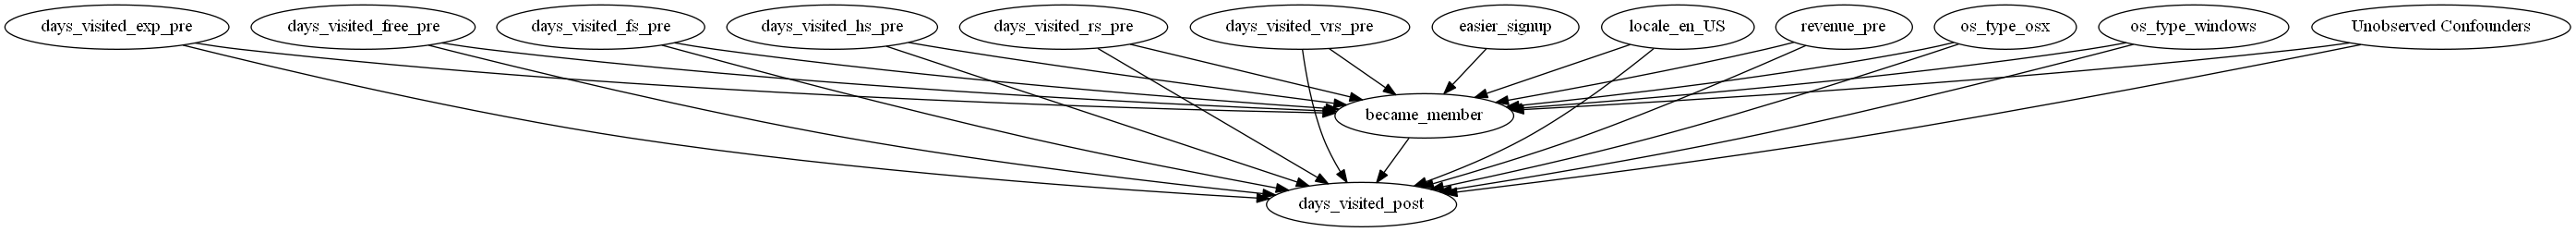

In [8]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(model._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    model.view_model() 

In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'revenue_pre', 'days_visited_exp_pre', 'days_visited_free_pre', 'os_type_osx', 'days_visited_hs_pre', 'days_visited_fs_pre', 'days_visited_vrs_pre', 'os_type_windows', 'locale_en_US', 'days_visited_rs_pre']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['easier_signup']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(Expectation(days_visited_post|revenue_pre,days_visited_exp_pr
d[became_member]                                                              

                                                                              
e,days_visited_free_pre,os_type_osx,days_visited_hs_pre,days_visited_fs_pre,da
                                                                              

                                                                     
ys_visited_vrs_pre,os_type_windows,locale_en_US,days_visited_rs_pre))
                                                                     
Estimand assumption 1, Unconfoundedness: If U→{became_member} and U→days_visited_post then P(days_visited_post|became_member,revenue_pre,days_visited_exp_pre,days_visited_free_pre,os_type_osx,days_visited_hs_pre,days_vi

# Get Causal Effects with EconML

To learn a linear projection of the treatment effect, we use the `LinearIntentToTreatDRIV` EconML estimator. For a more flexible treatment effect function, use the `IntentToTreatDRIV` estimator instead. 

The model requires to define some nuissance models (i.e. models we don't really care about but that matter for the analysis): the model for how the outcome $Y$ depends on the features $X$ (`model_Y_X`) and the model for how the treatment $T$ depends on the instrument $Z$ and features $X$ (`model_T_XZ`). Since we don't have any priors on these models, we use generic boosted tree estimators to learn them. 

In [10]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

In [11]:
test_customers = X_data.iloc[:1000]
driv_estimate = model.estimate_effect(identified_estimand,
                                      method_name="iv.econml.ortho_iv.LinearIntentToTreatDRIV",
                                      target_units = test_customers,
                                      method_params={
                                          "init_params":{'model_T_XZ': model_T_XZ, 
                                                         'model_Y_X': model_Y_X,
                                                         'flexible_model_effect': flexible_model_effect,
                                                         'featurizer': PolynomialFeatures(degree=1, include_bias=False)
                                                        },
                                          "fit_params":{}})
print(driv_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(Expectation(days_visited_post|revenue_pre,days_visited_exp_pr
d[became_member]                                                              

                                                                              
e,days_visited_free_pre,os_type_osx,days_visited_hs_pre,days_visited_fs_pre,da
                                                                              

                                                                     
ys_visited_vrs_pre,os_type_windows,locale_en_US,days_visited_rs_pre))
                                                                     
Estimand assumption 1, Unconfoundedness: If U→{became_member} and U→days_visited_post then P(days_visited_post|became_member,revenue_pre,days_visited_exp_pre,days_visited_

In [12]:
true_customer_TE = TE_fn(test_customers)
print("True ATE on test data: ", true_customer_TE.mean())

True ATE on test data:  1.9633999999999998


In [13]:
econml_model = driv_estimate._estimator_object

In [14]:
# Compare learned coefficients with true model coefficients\
econml_coefs = econml_model.coef_.flatten()
coef_indices = np.arange(econml_coefs.shape[0])
# Calculate error bars
coef_error = np.asarray(econml_model.coef__interval()).reshape(2, coef_indices.shape[0]) # 90% confidence interval for coefficients
coef_error[0, :] = econml_coefs - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - econml_coefs

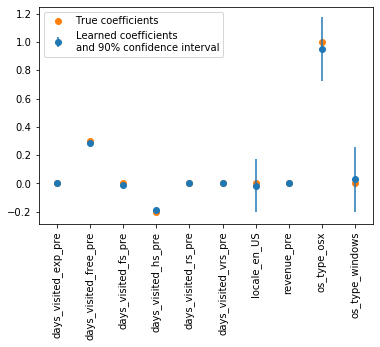

In [15]:
plt.errorbar(coef_indices, econml_coefs, coef_error, fmt="o", label="Learned coefficients\nand 90% confidence interval")
plt.scatter(coef_indices, true_coefs, color='C1', label="True coefficients")
plt.xticks(coef_indices, X_data.columns, rotation='vertical')
plt.legend()
plt.show()

We notice that the coefficients estimates are pretty close to the true coefficients for the linear treatment effect function. 

We can also use the `model.summary` function to get point estimates, p-values and confidence intervals. From the table below, we notice that only the **days_visited_free_pre**, **days_visited_hs_pre** and **os_type_osx** features are statistically significant (the confidence interval doesn't contain $0$, p-value < 0.05) for the treatment effect. 

In [16]:
econml_model.summary(feat_name=X_data.columns)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
days_visited_exp_pre,-0.0,0.007,-0.053,0.958,-0.012,0.011
days_visited_free_pre,0.286,0.007,38.484,0.0,0.274,0.299
days_visited_fs_pre,-0.01,0.007,-1.449,0.147,-0.021,0.001
days_visited_hs_pre,-0.19,0.007,-28.031,0.0,-0.201,-0.179
days_visited_rs_pre,0.0,0.007,0.05,0.96,-0.011,0.011
days_visited_vrs_pre,-0.0,0.007,-0.063,0.95,-0.011,0.011
locale_en_US,-0.017,0.113,-0.154,0.878,-0.204,0.169
revenue_pre,-0.0,0.0,-0.877,0.38,-0.0,0.0
os_type_osx,0.95,0.139,6.839,0.0,0.721,1.178
os_type_windows,0.027,0.139,0.198,0.843,-0.201,0.255


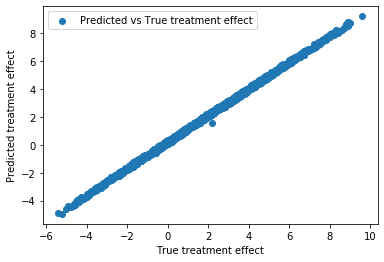

In [17]:
# How close are the predicted treatment effect to the true treatment effects for 1000 users?
plt.scatter(true_customer_TE, econml_model.effect(test_customers), label="Predicted vs True treatment effect")
plt.xlabel("True treatment effect")
plt.ylabel("Predicted treatment effect")
plt.legend()
plt.show()

# Test Estimate Robustness with DoWhy

### Add Random Common Cause

How robust are our estimates to adding another confounder? We use DoWhy to test this!

In [18]:
res_random = model.refute_estimate(
    identified_estimand, driv_estimate, method_name="random_common_cause"
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre+w_random | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows


Refute: Add a Random Common Cause
Estimated effect:2.0701305373810848
New effect:2.0795260724413565



### Add Unobserved Common Cause

How robust are our estimates to unobserved confounders? Since we assume we have a valid instrument, adding an unobserved confounder should not affect the estimates much. We use DoWhy to test this!

In [19]:
res_unobserved = model.refute_estimate(
    identified_estimand, driv_estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows


Refute: Add an Unobserved Common Cause
Estimated effect:2.0701305373810848
New effect:2.2968388136627262



### Replace Treatment with a Random (Placebo) Variable

What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be $0$. We use DoWhy to investigate!

In [20]:
res_placebo = model.refute_estimate(
    identified_estimand, driv_estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=5
)
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 5 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~placebo+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~placebo+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,lo

Refute: Use a Placebo Treatment
Estimated effect:2.0701305373810848
New effect:-31.89547363195543
p value:0.17239742963943705



While the "New effect" is not zero, the p-value is greater than 0.05 which means that we cannot reject the null hypothesis that $0$ is under the average treatment effect distribution. Increasing `num_simulations` should produce a "New effect" closer to $0$. 

### Remove a Random Subset of the Data

Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

In [21]:
# Removing a random subset of the data
res_subset = model.refute_estimate(
    identified_estimand, driv_estimate,
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=5)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 80000.0 each
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+revenue_pre+days_visited_exp_pre+days_visited_free_pre+os_type_osx+days_visited_hs_pre+days_visited_fs_pre+days_visited_vrs_pre+os_type_windows+locale_en_US+days_visited_rs_pre | days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vr

Refute: Use a subset of data
Estimated effect:2.0701305373810848
New effect:2.051414814591065
p value:0.2996140747559024



The "New effect" is close to the estimated effect from the original dataset and the p-value is greater than 0.05. Thus, we cannot reject the null hypothesis that the estimated effect is under the average treatment effect distribution. 

# Understand Treatment Effects with EconML

EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by the any of the EconML estimators. In the figure below we can see in dark red users who respond negatively to the membership program and in dark green users who respond positively.

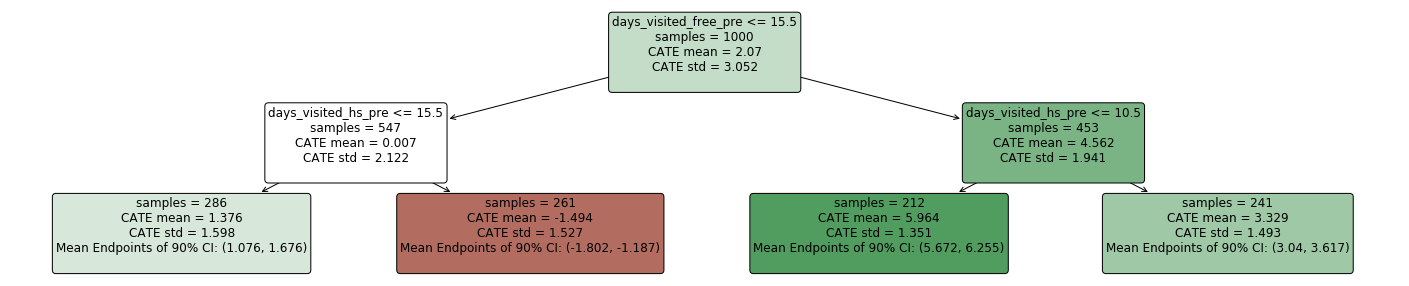

In [22]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(econml_model, test_customers)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)

# Make Policy Decisions with EconML

Interventions usually have a cost: incetivizing a user to become a member can be costly (e.g by offering a discount). Thus, we would like to know what customers to target to maximize the profit from their increased engagement. This is the **treatment policy**. 

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably. 

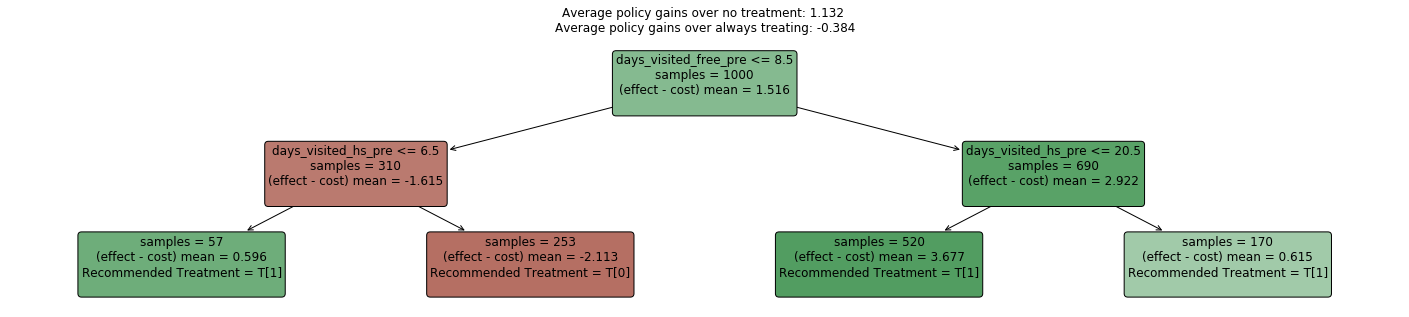

In [23]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(econml_model, test_customers, sample_treatment_costs=0.2)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)

# Conclusions

In this notebook, we have demonstrated the power of using EconML and DoWhy to:

* Get valid causal insights in seemingly impossible scenarios
* Test causal assumptions and investigate the robustness of the resulting estimates
* Intepret individual-level treatment effects
* Build policies around the learned effects

To learn more about what EconML can do for you, visit the [website](https://aka.ms/econml), [GitHub page](https://github.com/microsoft/EconML) or [docummentation](https://econml.azurewebsites.net/).

To learn more about what DoWhy can do for you, visit the [GitHub page](https://github.com/microsoft/dowhy) or [documentation](https://microsoft.github.io/dowhy/index.html).